In [78]:
import pandas as pd
import numpy as np
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from scipy.stats import pointbiserialr
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

np.random.seed(5151)
rpe_df = pd.read_csv('./raw_data/rpe.csv')
rpe_df['BestOutOfMyself'] = rpe_df['BestOutOfMyself'].map({'Absolutely': 3, 'Not at all': 0, 'Somewhat': 1})
rpe_df['Training'] = rpe_df['Training'].map({'Yes': 1, 'No': 0})

In [79]:
# Recomputing Session loads and daily loads
rpe_df['SessionLoad'] = rpe_df['Duration'] * rpe_df['RPE']

rpe_df.Date = pd.to_datetime(rpe_df.Date)
rpe_df = rpe_df.sort_values(by = 'Date', ascending = True)
rpe_df['DailyLoad'] = rpe_df.groupby(['Date','PlayerID'])['SessionLoad'].transform('sum')
rpe_df[rpe_df['Date'] == '2017-09-06']
rpe_df['DailyLoad'] = rpe_df.groupby(['Date','PlayerID'])['DailyLoad'].fillna(method='ffill')

In [80]:
# Recomputing acute load
temp = rpe_df[['Date','PlayerID','DailyLoad']].drop_duplicates()
past7Days = temp.groupby('PlayerID').rolling('7d', on='Date')['DailyLoad'].sum().reset_index()
past7Days['newAcuteLoad'] = (past7Days['DailyLoad'] / 7.).round(2)
past7Days = past7Days.drop(columns = 'DailyLoad')

rpe_df = pd.merge(rpe_df, past7Days, how="left", on=["Date", "PlayerID"])

In [81]:
past30Days = temp.groupby('PlayerID').rolling('30d', on='Date')['DailyLoad'].sum().reset_index()
past30Days['newChronicLoad'] = (past30Days['DailyLoad'] / 30.).round(2)
past30Days = past30Days.drop(columns = 'DailyLoad')

rpe_df = pd.merge(rpe_df, past30Days, how="left", on=["Date", "PlayerID"])
print(rpe_df[rpe_df['PlayerID'] == 1])

           Date  PlayerID  Training        SessionType  Duration  RPE  \
1    2017-08-01         1         1              Speed      60.0  3.0   
2    2017-08-01         1         1           Strength      90.0  4.0   
19   2017-08-02         1         0                NaN       NaN  NaN   
41   2017-08-03         1         0                NaN       NaN  NaN   
114  2017-08-07         1         1             Skills      60.0  3.0   
...         ...       ...       ...                ...       ...  ...   
8797 2018-07-16         1         1              Speed      30.0  2.0   
8814 2018-07-17         1         1             Skills      60.0  3.0   
8815 2018-07-17         1         1  Mobility/Recovery      30.0  0.0   
8832 2018-07-18         1         0                NaN       NaN  NaN   
8840 2018-07-19         1         1             Skills      60.0  3.0   

      SessionLoad  DailyLoad  AcuteLoad  ChronicLoad  AcuteChronicRatio  \
1           180.0      540.0       77.1        1

In [82]:
rpe_df.drop(['ChronicLoad','AcuteLoad'],axis = 1, inplace = True)
rpe_df.rename(columns = {'newChronicLoad':'ChronicLoad','newAcuteLoad':'AcuteLoad'}, inplace = True)
rpe_df['AcuteChronicRatio'] = (rpe_df['AcuteLoad'] / rpe_df['ChronicLoad']).round(2)
print(rpe_df[rpe_df['PlayerID'] == 1])

           Date  PlayerID  Training        SessionType  Duration  RPE  \
1    2017-08-01         1         1              Speed      60.0  3.0   
2    2017-08-01         1         1           Strength      90.0  4.0   
19   2017-08-02         1         0                NaN       NaN  NaN   
41   2017-08-03         1         0                NaN       NaN  NaN   
114  2017-08-07         1         1             Skills      60.0  3.0   
...         ...       ...       ...                ...       ...  ...   
8797 2018-07-16         1         1              Speed      30.0  2.0   
8814 2018-07-17         1         1             Skills      60.0  3.0   
8815 2018-07-17         1         1  Mobility/Recovery      30.0  0.0   
8832 2018-07-18         1         0                NaN       NaN  NaN   
8840 2018-07-19         1         1             Skills      60.0  3.0   

      SessionLoad  DailyLoad  AcuteChronicRatio  ObjectiveRating  FocusRating  \
1           180.0      540.0              

In [83]:
print(rpe_df.shape[0])
print(rpe_df.shape[0]- rpe_df.dropna().shape[0])
print(rpe_df.shape[0])

8860
7152
8860


In [84]:
rpe_df = rpe_df.dropna()

In [85]:
dummy_session_type = pd.get_dummies(rpe_df, columns = ['SessionType'] )
number_session_type = rpe_df.copy()
number_session_type['SessionType'] = rpe_df['SessionType'].map({'Combat': 0, 'Conditioning': 1,
                                                                 'Game': 2,
                                                                 'Mobility/Recovery': 3,
                                                                 'Skills': 4,
                                                                 'Speed': 5,'Strength': 6})

In [86]:
dummy_player_data = dummy_session_type.groupby('PlayerID',as_index = False).mean()
dummy_player_data = dummy_player_data.drop(['PlayerID'], axis=1)
num_player_data = number_session_type.groupby('PlayerID',as_index = False).mean()
num_player_data = num_player_data.drop(['PlayerID'], axis=1)

chi_square_value,p_value = calculate_bartlett_sphericity(num_player_data)
print(chi_square_value, p_value)

print(player_data.head())

190.6351264821661 1.646039727264444e-14
   PlayerID  Training   Duration       RPE  SessionLoad   DailyLoad  \
0         1  1.000000  73.333333  3.962963   304.259259  847.222222   
1         2  1.000000  45.000000  2.500000   142.500000  570.000000   
2         3  0.995951  58.740891  5.222672   312.688259  806.080972   
3         4  1.000000  65.250000  4.112500   288.875000  727.250000   
4         5  1.000000  56.500000  3.777778   242.555556  837.555556   

   AcuteChronicRatio  ObjectiveRating  FocusRating  BestOutOfMyself  \
0           1.328148         8.629630     9.777778         2.851852   
1           4.290000         9.000000     8.000000         3.000000   
2           1.154980         8.004049     8.000000         3.000000   
3           1.145375         7.962500     7.962500         3.000000   
4           1.398889         8.944444     9.611111         3.000000   

    AcuteLoad  ChronicLoad  SessionType_Combat  SessionType_Conditioning  \
0  403.015556   319.420000    

In [87]:
new_rpe.shape[0]
kmo_all,kmo_model=calculate_kmo(num_player_data)
print(kmo_all, kmo_model)

[0.21567603 0.35158996 0.39068185 0.2769437  0.39067862 0.49146777
 0.22863533 0.54027162 0.60688263 0.57739519 0.58481032 0.53645715] 0.440294608310951


# Session type as dummy variables

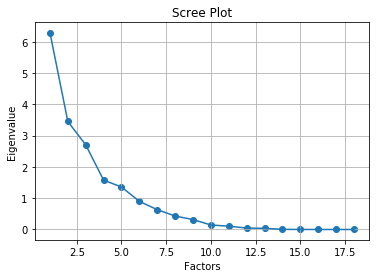

In [88]:
factor_number_tester = FactorAnalyzer(n_factors=10, rotation="varimax") # Using number of factors = number of columns
factor_number_tester.fit(dummy_player_data) 
ev, v = factor_number_tester.get_eigenvalues()

plt.scatter(range(1,dummy_player_data.shape[1]+1),ev)
plt.plot(range(1,dummy_player_data.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [89]:
fa = FactorAnalyzer(5, rotation="varimax")
fa.fit(dummy_player_data)
print(dummy_player_data.columns)
print(fa.loadings_)
print(np.where(fa.loadings_>0.7))
print(fa.get_factor_variance())

Index(['Training', 'Duration', 'RPE', 'SessionLoad', 'DailyLoad',
       'AcuteChronicRatio', 'ObjectiveRating', 'FocusRating',
       'BestOutOfMyself', 'AcuteLoad', 'ChronicLoad', 'SessionType_Combat',
       'SessionType_Conditioning', 'SessionType_Game',
       'SessionType_Mobility/Recovery', 'SessionType_Skills',
       'SessionType_Speed', 'SessionType_Strength'],
      dtype='object')
[[ 0.00647976 -0.28798022 -0.10376725  0.35383489  0.25661657]
 [ 0.0619483   0.70762136  0.44077603  0.15437369  0.29543227]
 [-0.23844304  0.81455674 -0.33568164 -0.13739826  0.0399805 ]
 [-0.0624797   0.98018673  0.10622587  0.02078443  0.11648831]
 [ 0.4000867   0.78717114  0.28195956  0.21576986  0.15214904]
 [-0.05787399 -0.1871248   0.41398485  0.65072021 -0.36978548]
 [ 0.90831739 -0.101174    0.1740587   0.06807411  0.04361947]
 [ 0.79548592 -0.06810862  0.17620858 -0.13316444  0.4257702 ]
 [ 0.68483656  0.00567385  0.54018419 -0.20355974  0.17917145]
 [ 0.75485071  0.51195537  0.26414504

# Session types encoded as numbers

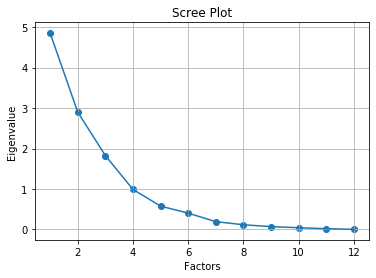

In [90]:
factor_number_tester = FactorAnalyzer(n_factors=10, rotation="varimax") # Using number of factors = number of columns
factor_number_tester.fit(num_player_data) 
ev, v = factor_number_tester.get_eigenvalues()

plt.scatter(range(1,num_player_data.shape[1]+1),ev)
plt.plot(range(1,num_player_data.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [91]:
fa = FactorAnalyzer(3, rotation="varimax")
fa.fit(num_player_data)
print(num_player_data.columns)
print(fa.loadings_)
print(np.where(fa.loadings_>0.7))
print(fa.get_factor_variance())

Index(['Training', 'SessionType', 'Duration', 'RPE', 'SessionLoad',
       'DailyLoad', 'AcuteChronicRatio', 'ObjectiveRating', 'FocusRating',
       'BestOutOfMyself', 'AcuteLoad', 'ChronicLoad'],
      dtype='object')
[[-0.03269261 -0.19755691  0.24777761]
 [ 0.52733887  0.46777589  0.57329311]
 [ 0.17703937  0.82972939  0.10238803]
 [-0.38609221  0.63925393 -0.53493861]
 [-0.08778348  0.97151699 -0.24039852]
 [ 0.37381448  0.86473063 -0.01100794]
 [-0.04029718  0.05093691  0.75734879]
 [ 0.88730212 -0.02661675  0.05725989]
 [ 0.87241346 -0.02223578 -0.12497518]
 [ 0.84386277  0.14104249  0.08569697]
 [ 0.71589352  0.49577616 -0.17623357]
 [ 0.5756266   0.37913814 -0.6347999 ]]
(array([ 2,  4,  5,  6,  7,  8,  9, 10], dtype=int64), array([1, 1, 1, 2, 0, 0, 0, 0], dtype=int64))
(array([3.71299647, 3.45977395, 1.77846182]), array([0.30941637, 0.2883145 , 0.14820515]), array([0.30941637, 0.59773087, 0.74593602]))
